In [75]:
import csv
import random
from collections import Counter
import numpy as np


def read_tsv(filename, percentage=1, read_less=False, readlines=-1):
    ret = []
    cnt = 0
    with open(filename, 'rb') as csvfile:
        rowreader = csv.reader(csvfile, delimiter='\t')
        for row in rowreader:
            cnt += 1
            if read_less and cnt > readlines:
                break
            if random.random() < percentage:
                assert len(row) == 2, "What!!"
                ret.append(tuple(row))
    return ret



class SVAgreementCorpus():
    def __init__(self, cut_off=-1):
        self.train_file = './rnn_agr_simple/numpred.train'
        self.val_file = './rnn_agr_simple/numpred.val'
        self.data = []
        self.val_data = []
        self.idx_to_word = {}
        self.word_to_idx = {}
        self.vocab_size = len(self.word_to_idx)

        self.word_to_idx[u'PAD'] = 0
        self.word_to_idx[u'OOV'] = 1
        self.load_data(cut_off)

    def pad_list(self, x, desired_len):
        x.extend([0]*(desired_len-len(x)))

    def get_batch(self, data, size=1):
        batch_mask = np.random.choice(len(data), size)

        #Processing X, y
        batch = data[batch_mask]
        X_batch, y_batch, sents_batch = np.hsplit(batch, 3)
        X_batch = X_batch.flatten()



        y_batch = np.reshape(y_batch == 'VBP', -1)  # 'VBP' = 0, 'VBZ' = 1

        # length of sequences
        lengths = np.vectorize(len)(X_batch)
        max_len = np.max(lengths)

        # padding X_batch
        np.vectorize(self.pad_list)(X_batch, max_len)

        # reverse sorted order
        order = np.flipud(np.argsort(lengths))
        X_batch = X_batch[order]
        y_batch = y_batch[order]
        sents_batch = sents_batch[order]

        # converts numpy 1d array of list to numpy 2d array
        X_batch = np.concatenate(X_batch).reshape(len(X_batch), *np.shape(X_batch[0]))
        y_batch = np.array(y_batch)

        return X_batch, y_batch, sents_batch, lengths[order]


    def __len__(self):
        return len(self.data)

    def load_data(self, cut_off=-1, train_percentage=0.1):
        '''
        train_percentage - what percentage of training data to use (uniformly sampled)
        '''

        assert self.train_file is not None, 'Filename error'

        raw_data = read_tsv(self.train_file, percentage=train_percentage)

        for target, sent in raw_data:
            tokens = sent.split(' ')
            encoded_sent = []
            for token in tokens:
                if token not in self.word_to_idx:
                    self.word_to_idx[token] = len(self.word_to_idx)
                encoded_sent.append(self.word_to_idx[token])
            self.data.append((encoded_sent, target, sent))

        self.idx_to_word = {v: k for k, v in self.word_to_idx.iteritems()}
        self.vocab_size = len(self.word_to_idx)
        self.data = np.array(self.data)

        val_data = read_tsv(self.val_file, percentage=train_percentage)
        for target, sent in val_data:
            tokens = sent.split(' ')
            encoded_sent = [self.word_to_idx[token] if token in self.word_to_idx else self.word_to_idx[u'OOV'] for token in tokens]
            self.val_data.append((encoded_sent, target, sent))
        self.val_data = np.array(self.val_data)

        if cut_off > 0:
            self.data = self.data[:100]
            self.val_data = self.val_data[:100]

In [17]:
baby_dataset = SVAgreementCorpus(cut_off=100)

In [36]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
from torch.autograd import Variable

import torch


class LinzenLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, dataset):
        super(LinzenLSTM, self).__init__()

        self.word_embeddings = nn.Embedding(dataset.vocab_size, embedding_dim=embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1)

        self.regression_layer = nn.Linear(hidden_dim, 2)
        self.softmax = nn.Softmax()

    def init_hidden(self):
        return (Variable(torch.zeros(1, 1, self.hidden_dim)),
                Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, X_batch, lengths, hidden=None):
        embedded_X = self.word_embeddings(X_batch)  # N x max_len x k
        packed_X = self.pad_and_pack(embedded_X, lengths)
        lstm_out, self.hidden = self.lstm(packed_X, hidden)
        h, c = self.hidden
        unnorm_probs = self.regression_layer(h[0])
        return unnorm_probs

    def pad_and_pack(self, X_batch, lengths):
        # pack padded sequence
        X_batch = utils.rnn.pack_padded_sequence(X_batch, lengths, batch_first=True)
        return X_batch


In [45]:
def accuracy(dataset, model, train_or_val):
    model.train(mode=False)
    if train_or_val == 'train':
        X, y, _, lengths = dataset.get_batch(data=dataset.data, size=len(dataset.data))
    elif train_or_val == 'val':
        X, y, _, lengths = dataset.get_batch(data=dataset.val_data, size=len(dataset.val_data))
        
    X = Variable(torch.LongTensor(X), requires_grad=False)  # N x max_len
    y = Variable(torch.LongTensor(y.astype(int)), requires_grad=False)

    y_pred = model.forward(X, lengths)
    
    _, pred = torch.max(y_pred, 1)
    accurate = (pred==y)
    
    return accurate.data.numpy().mean()

In [37]:
def train(dataset, model, args, early_stopping=True, debug=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])

    
    train_loss = []
    validation_loss = []
    best_accu_epoch = (0, 0)    # (accuracy, epoch)
    
    iterations = len(dataset) / args['batch_size']
    threshold = 0
    for epoch in range(args['epochs']):
        model.train(mode=True)
        epoch_loss = 0
        for iter in range(iterations):
            optimizer.zero_grad()

            X_batch, y_batch, sents_batch, lengths = dataset.get_batch(data=dataset.data, size=args['batch_size'])

            X_batch = Variable(torch.LongTensor(X_batch), requires_grad=False)      # N x max_len
            y_batch = Variable(torch.LongTensor(y_batch.astype(int)), requires_grad=False)

            y_pred = model.forward(X_batch, lengths)

            loss = criterion(y_pred, target=y_batch)
            epoch_loss += loss.data.numpy()[0]

            if iter % 100 == 0 and debug:
                print 'epoch=', epoch, 'iteration=', iter, 'Loss=', loss.data.numpy()[0]

            loss.backward()
            optimizer.step()
        epoch_loss /= iterations
        
        # validation
        model.train(mode=False)
        X_val, y_val, _, lengths = dataset.get_batch(data=dataset.val_data, size=len(dataset.val_data))

        X_val = Variable(torch.LongTensor(X_val), requires_grad=False)  # N x max_len
        y_val = Variable(torch.LongTensor(y_val.astype(int)), requires_grad=False)

        y_pred = model.forward(X_val, lengths)

        val_loss = criterion(y_pred, target=y_val).data.numpy()[0]
        val_accu = accuracy(dataset, model, 'val')
        train_loss.append(epoch_loss)
        validation_loss.append(val_loss)
        
        if val_accu > best_accu_epoch[0]:
            best_accu_epoch = (val_accu, epoch)
            torch.save(model, './save/' + str(args['lr']) + '.pt')
        else:
            threshold += 1
            if threshold > 3 and early_stopping:
                break
        
        
        if epoch%7 == 0:
            print 'epoch=', epoch, 'Training Loss=', epoch_loss, 'Val loss=', val_loss, 'Val_accuracy=', val_accu
        
        
    return train_loss, validation_loss, best_accu_epoch

In [38]:
args = {
        'lr': 0.001,
        'epochs': 50,
        'batch_size': 20
    }
overfit_model = LinzenLSTM(embedding_dim=50, hidden_dim=50, dataset=baby_dataset)   #dataset

In [39]:
train_loss, val_loss, val_accuracy = train(baby_dataset, overfit_model, args, early_stopping=False)

epoch= 0 Training Loss= 0.7087302803993225 Val loss= 0.7003713 Val_accuracy= 0.42
epoch= 7 Training Loss= 0.6056385695934295 Val loss= 0.82651895 Val_accuracy= 0.57
epoch= 14 Training Loss= 0.5129803359508515 Val loss= 0.77102935 Val_accuracy= 0.58
epoch= 21 Training Loss= 0.6151915490627289 Val loss= 0.69230515 Val_accuracy= 0.65
epoch= 28 Training Loss= 0.5265212237834931 Val loss= 0.7781054 Val_accuracy= 0.53
epoch= 35 Training Loss= 0.3025146394968033 Val loss= 0.950897 Val_accuracy= 0.58
epoch= 42 Training Loss= 0.37516801357269286 Val loss= 0.9516104 Val_accuracy= 0.53
epoch= 49 Training Loss= 0.23143481612205505 Val loss= 1.1290973 Val_accuracy= 0.62


In [31]:
from matplotlib import pyplot
def plot_losses(loss, val_loss):
    fig = pyplot.figure()
    pyplot.plot(loss)
    pyplot.plot(val_loss)
    pyplot.show()
    

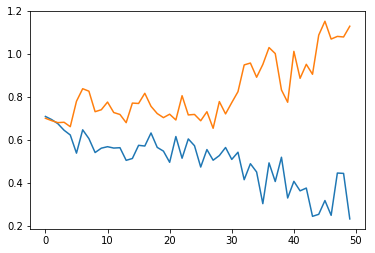

In [40]:
plot_losses(train_loss, val_loss)

In [13]:
dataset = SVAgreementCorpus()

In [94]:
lrs = [0.01, 0.003, 0.001, 0.0003]

args = {
    'lr': 0.001,
    'epochs': 50,
    'batch_size': 20
}

best_args = {
    'lr': None,
    'epochs': None
}

accuies = []
max_accu = 0
for lr in lrs:
    args['lr'] = lr
    model = LinzenLSTM(embedding_dim=50, hidden_dim=50, dataset=baby_dataset)   #dataset
    train_loss, val_loss, val_accu_epoch = train(dataset, model, args)
    accu, epoch = val_accu_epoch
    
    accuies.append(accu)
    if accu > max_accu:
        best_args['lr'] = lr
        best_args['epochs'] = epoch
    

epoch= 0 Training Loss= 0.6370767169387628 Val loss= 0.6421433 Val_accuracy= 0.6712243629583592
epoch= 7 Training Loss= 0.05381392318390455 Val loss= 0.25615954 Val_accuracy= 0.911124922311995
epoch= 0 Training Loss= 0.6282276061409754 Val loss= 0.6358129 Val_accuracy= 0.6724673710379118
epoch= 7 Training Loss= 0.04811267036142105 Val loss= 0.34138116 Val_accuracy= 0.9049098819142325
epoch= 0 Training Loss= 0.6329175602882466 Val loss= 0.63597697 Val_accuracy= 0.6805469235550031
epoch= 0 Training Loss= 0.6261977262530767 Val loss= 0.63235706 Val_accuracy= 0.6494717215661902
epoch= 7 Training Loss= 0.574334328732592 Val loss= 0.5340393 Val_accuracy= 0.7650714729645742


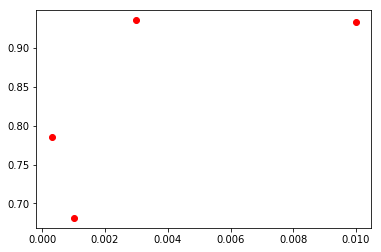

In [97]:
pyplot.plot(lrs, accuies, 'ro')

In [4]:
best_model = torch.load('./save/'+'0.0003.pt')

In [10]:
print best_args

{'epochs': 11, 'lr': 0.003}


In [41]:
print accuracy(baby_dataset, overfit_model, 'val')

0.59


In [47]:
args = {
        'lr': 0.003,
        'epochs': 11,
        'batch_size': 20
    }
again_model = LinzenLSTM(embedding_dim=50, hidden_dim=50, dataset=dataset)   

In [48]:
train_loss, val_loss, val_accuracy = train(dataset, again_model, args, early_stopping=False)

epoch= 0 Training Loss= 0.4266413403518873 Val loss= 0.4561704 Val_accuracy= 0.8309948979591837
epoch= 7 Training Loss= 0.21431479497562947 Val loss= 0.2642319 Val_accuracy= 0.9113520408163265


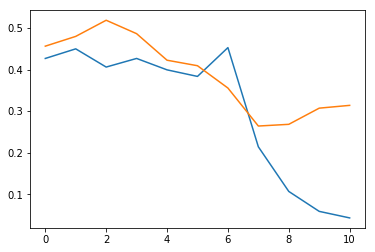

In [51]:
pyplot.plot(train_loss)
pyplot.plot(val_loss)
pyplot.show()

In [52]:
print accuracy(dataset, again_model, 'val')

0.9253826530612245


In [53]:
print train_loss


[0.4266413403518873, 0.4497224258560708, 0.4059518188363014, 0.42665023553346454, 0.3992442810418885, 0.3834650787790228, 0.45268846244951866, 0.21431479497562947, 0.10704819751089158, 0.05913439380938601, 0.04341629295048627]


In [84]:
def read_val_file(file_name, dataset, read_less=False, lines=-1):
    raw_data = read_tsv(file_name, read_less=read_less, readlines=lines)

    data = []
    for target, sent in raw_data:
        tokens = sent.split(' ')
        encoded_sent = [dataset.word_to_idx[token] if token in dataset.word_to_idx else dataset.word_to_idx[u'OOV'] for token in tokens]
        data.append((encoded_sent, target, sent))
    data = np.array(data)
    
    return data

In [108]:
def test_accuracy(data, model, show_sents=False):
    model.train(mode=False)
    X, y, sents, lengths = dataset.get_batch(data, size=len(data))
        
    X = Variable(torch.LongTensor(X), requires_grad=False)  # N x max_len
    y = Variable(torch.LongTensor(y.astype(int)), requires_grad=False)

    y_pred = model.forward(X, lengths)
    
    _, pred = torch.max(y_pred, 1)
    accurate = (pred==y)
    
    if show_sents:
        cnt = 0
        for idx, pred in enumerate(accurate):
            if cnt > 40:
                break
            if pred.data.numpy()[0] == 0:
                cnt += 1
                print sents[idx]
    
    return accurate.data.numpy().mean()

In [111]:
attractor_accu = []
for k in range(3):
    filename = './rnn_agr_simple/' + 'numpred.test.' + str(k)
    data = read_val_file(filename, dataset, read_less=True, lines=2000)
    att_acc = test_accuracy(data, again_model, show_sents=True)
    print att_acc
    attractor_accu.append(att_acc)
    

['usually , but not always , a private values model assumes that the values are independent across NNS , whereas a common value model usually assumes that the values']
['usually , but not always , a private values model assumes that the values are independent across NNS , whereas a common value model usually assumes that the values']
['it should also be noted that virtually nothing posted to a web forum is going to be considered useful here , since with very rare exceptions a web forum']
["NNP explorer is similar in many ways to NNP 's internet software , as NNP has an email client built in and both programs"]
['in one of the meeting rooms on the eighth level ( the assembly hall - see below ) , the NNS alone']
['in one of the meeting rooms on the eighth level ( the assembly hall - see below ) , the NNS alone']
['in june 2007 , NNP held a public wedding ceremony in NNP with her partner NNP NNP , although same-sex marriages']
['NNP chan has been sometimes VBN a NN , often by his politica

["in medieval times , members of the NN were territorial NNS in counties NNP and NNP , and two places called NNP , ( from `` NN '' , a settlement ) , one in county NNP and the other in county NNP , further"]
["i do have skill and knowledge in various areas including wp editing but have n't judged whether NNP 's skill or knowledge is similar to mine , although NNP 's views in the area of the JJ disagreement with NNP"]
["i do have skill and knowledge in various areas including wp editing but have n't judged whether NNP 's skill or knowledge is similar to mine , although NNP 's views in the area of the JJ disagreement with NNP"]
["i do have skill and knowledge in various areas including wp editing but have n't judged whether NNP 's skill or knowledge is similar to mine , although NNP 's views in the area of the JJ disagreement with NNP"]
["it shows that the field of NNP 's electricity and the field of NNP 's NN are distinct ; although both make different assumptions about physical reality

In [86]:
for k in [4, 5]:
    filename = './rnn_agr_simple/' + 'numpred.test.' + str(k)
    data = read_val_file(filename, dataset)
    att_acc = test_accuracy(data, again_model)
    print att_acc
    attractor_accu.append(att_acc)

0.3333333333333333
0.2578616352201258


In [87]:
print attractor_accu


[0.92, 0.7615, 0.5765, 0.3333333333333333, 0.2578616352201258]


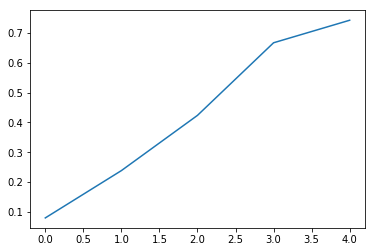

In [94]:
err = [ ]
for acc in attractor_accu:
    err.append(1-acc)
pyplot.plot(err)
pyplot.show()


In [109]:
test_accuracy(data, again_model, show_sents=True)

['square NNS with a brief but JJ ( given the reference section ) citation after the relevant NN or NN']
['the main external cooperation partners that provide support to the JJ government for water supply and NN']
['these NNS of human excellence , including love for the truth , courage , and NN ,']
['JJ JJ forms ( such as that of the symphony , concerto , opera or NN , for example ) usually']
['the final chapters , on the NNP public housing NN case and the NN of public housing ,']
['WRB NN can apply certain relationships itself ; for example , if the values of the subject property of a picture and the name property of a contact']
['several artifacts taken from the work house , including the door of a jail cell and the old prison register ,']
['the best solution with locally significant facilities ( be they churches , sports NNS , parks , etc )']
['similarly , the grades in a high school chemistry ( including lab work ) course']
['each NN a board of professors , students , administrators

0.31446540880503143

In [112]:
print dataset.word_to_idx.keys()

['writings', 'yellow', 'four', 'woods', 'hanging', 'cyprus', 'increase', 'eligible', 'electricity', 'hermann', 'lord', 'sinking', 'saskatchewan', 'regional', 'fur', 'bringing', 'scholar', 'wooden', 'succession', 'south-west', 'commented', 'charter', 'tired', 'miller', 'pulse', 'second', 'errors', 'thunder', 'cooking', 'contributed', 'fingers', 'fossil', 'increasing', 'specialist', 'hero', 'reporter', 'herb', 'error', 'here', 'atoms', 'reported', 'china', 'cult', 'affiliated', 'kids', 'k', 'reports', 'controversy', 'military', 'criticism', 'golden', 'projection', 'classification', 'explained', 'norse', 'replace', 'brought', 'stern', 'unit', 'opponents', 'dna', 'occupying', 'symphony', 'music', 'therefore', 'passport', 'strike', 'until', 'females', 'relay', 'populations', 'successful', 'binding', 'glass', '91', '90', 'hole', 'hold', '97', 'circumstances', 'wikiproject', 'locked', 'famed', 'blade', 'temperatures', 'concepts', 'admits', 'example', 'wang', 'household', 'artillery', 'organiz

In [129]:
from nltk.corpus import brown
from nltk import ngrams
from nltk import FreqDist
import numpy as np
from collections import Counter


class FreqBrownDataset(object):
    def __init__(self, include_start=True):
        self.words = brown.words()
        self.words = map(lambda x: x.lower(), self.words)
        self.total_word_cnt = len(self.words) + 2 * len(brown.sents())  # include START and END
        if include_start:
            self.words.append(u'START')
        self.words.append(u'END')
        self.vocab = set(self.words)


        self.vocab_len = len(self.vocab)
        self.word_to_idx = dict(zip(list(self.vocab), range(self.vocab_len)))

        self.sentences = []
        self.bigrams = []
        self.unigrams = []
        for sent in brown.sents():
            sentence = map(lambda x: x.lower(), sent)
            if include_start:
                sentence.insert(0, u'START')
            sentence.append(u'END')
            self.sentences.append(sentence)
            self.bigrams.extend(list(ngrams(sentence, 2)))
            self.unigrams.extend(sentence)

        self.unigram_freq = dict(Counter(self.unigrams))

        self.num_sentences = len(self.sentences)
        self.bigram_cnt = FreqDist(self.bigrams)
        self.bigram_len = len(self.bigram_cnt)
        self.bigram_idx = dict(zip(self.bigram_cnt.keys(), range(self.bigram_len)))
        self.bigram_freq = np.asarray(self.bigram_cnt.values())
        self.num_bigrams = len(self.bigram_cnt)

In [130]:
freqdata = FreqBrownDataset()

In [146]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
singular = ['life', 'nation', 'blog', 'chart', 'fan']
plural = ['lives', 'nations', 'blogs', 'charts', 'fans']

In [147]:
import nltk
import nltk.tokenize

cnt1 = 0
cnt2 = 0
pts = 100
for word in dataset.word_to_idx.keys():
    if cnt1 > pts and cnt2 > pts:
        break
    if cnt1 < pts and nltk.pos_tag(nltk.word_tokenize(word))[0][1] == 'NN' and (word in freqdata.unigram_freq and freqdata.unigram_freq[word] > 100):
        singular.append(word)
        cnt1 += 1
    if cnt2 < pts and nltk.pos_tag(nltk.word_tokenize(word))[0][1] == 'NNS' and  (word in freqdata.unigram_freq and freqdata.unigram_freq[word] > 100):
        plural.append(word)
        cnt2 += 1
print len(singular), len(plural)

105 93


In [200]:
X = []
y=[]
for word in singular:
    X.append(word)
    y.append(0)
for word in plural:
    X.append(word)
    y.append(1)
print singular
print plural

['life', 'nation', 'blog', 'chart', 'fan', 'increase', 'brought', 'unit', 'music', 'hold', 'example', 'want', 'machine', 'series', 'service', 'person', 'mouth', 'letter', 'result', 'nature', 'extent', 'country', 'union', 'life', 'child', 'east', 'right', 'son', 'support', 'floor', 'time', 'corps', 'choice', 'room', 'love', 'date', 'stress', 'course', 'square', 'training', 'city', 'future', 'saw', 'note', 'drive', 'hour', 'west', 'situation', 'summer', 'rest', 'dark', 'world', 'power', 'industry', 'act', 'image', 'congress', 'spirit', 'past', 'section', 'method', 'experience', 'action', 'door', 'company', 'science', 'beautiful', 'sense', 'plant', 'plane', 'trade', 'attitude', 'paper', 'found', 'england', 'research', 'number', 'show', 'play', 'plan', 'river', 'set', 'firm', 'fire', 'read', 'couple', 'continue', 'spring', 'religion', 'agreement', 'anything', 'line', 'influence', 'land', 'age', 'try', 'race', 'doubt', 'process', 'move', 'truth', 'society', 'length', 'system', 'lot']
['live

In [178]:
again_model.train(mode=False)
nX = []
embds = []
for word in X:
    x = Variable(torch.LongTensor([dataset.word_to_idx[word]]))
    out = again_model.word_embeddings(x)
    embds.append(out.data.numpy()[0])

In [183]:
embds = np.asarray(embds)
print embds

[[ 0.22227319 -0.07324667  0.18352717 ... -1.0102937   1.4540558
   0.28696075]
 [-0.32219166  0.95803815 -0.8690596  ...  1.290695    0.75507176
  -0.9994384 ]
 [ 0.21880071  0.5044457  -0.3551879  ...  1.8668016  -0.60911375
  -1.152307  ]
 ...
 [-1.5500245  -1.3036621   1.1253486  ...  0.11357416  0.00397282
   0.04472358]
 [-0.5956684  -1.9852366  -0.16762395 ...  0.19693345 -0.57112145
   0.12983014]
 [-0.29424086 -0.34373528  1.1693498  ...  0.4139107  -0.54571754
   0.4484114 ]]


In [195]:
print y

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [199]:
torch_embds = Variable(torch.FloatTensor(embds), requires_grad=False)
torch.svd(torch.t(torch_embds))
low_dim = torch.mm(out1,U1[:,:2])
    

TypeError: Type Variable doesn't implement stateless method svd

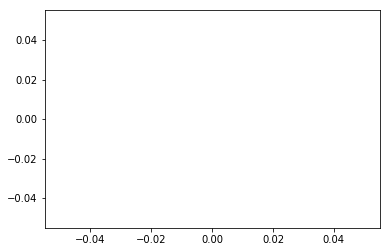

In [194]:
colors = ['navy', 'darkorange']
lw = 2

for color, i in zip(colors, [0, 1]):
    pyplot.scatter(X[y == i, 0], X[y == i, 1], color=color)

